In [37]:
# solite librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import sklearn
from tensorflow import keras
import os
import seaborn as sns
import random
import shutil
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas



# audio management
import librosa 
import librosa.display
import IPython.display as ipd
from pydub import AudioSegment


import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from keras.preprocessing.image import ImageDataGenerator


# 0. Abstract
Nel seguente notebook tenteremo di risolvere il problema della classificazione multiclasse di audio musicali in base ai loro generi. Per tale fine verrà utilizzato il dataset "GTZAN Genre Collection", scaricabile al seguente link : http://marsyas.info/downloads/datasets.html.
I 10 generi musicali presenti nel dataset sono i seguenti : Blues, Classical, Country, Disco, HipHop, Jazz, Metal, Pop, Reggae, Rock.


In [63]:
genres=['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

# 1. Feature extraction

Il nostro punto di partenza sono file audio della durata di 30 secondi :

In [55]:
ipd.Audio(r'C:\Users\paolo\OneDrive\Desktop\genr\genres\reggae\reggae.00010.wav')

Dobbiamo estrapolare da tali file delle features in grado di descrivere precisamente l'audio in maniera tale da poter definire un modello in grado di classificarli.

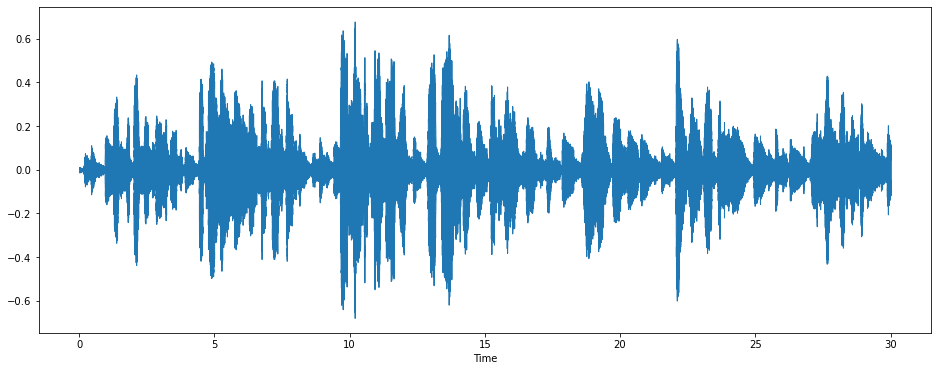

In [45]:
# carico il file audio attraverso la libreria librosa

x, sr = librosa.load(r'C:\Users\paolo\OneDrive\Desktop\genr\genres\reggae\reggae.00010.wav')

# visualizzazione del file audio 

plt.figure(figsize=(16, 6))
librosa.display.waveshow(x, sr=sr);

Zoommiamo per visualizzare meglio i dettagli del segnale.

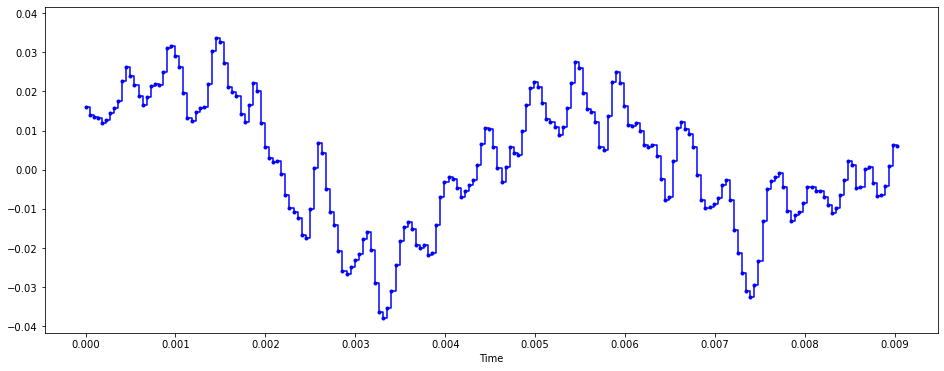

In [46]:
plt.figure(figsize=(16, 6))
librosa.display.waveshow(x[8900:9100], sr=sr, marker='.',color='blue');

### - Zero crossing rate
E' il tasso di cambiamento del segnale da positivo a negativo o viceversa.

In [33]:
# numero totale di zero crossing del mio file audio

zero_crossings = librosa.zero_crossings(x,pad=False)
print(np.sum(zero_crossings))

68085


### - Harmonics & Perceptrual

Harmonics sono caratteristiche che l'orecchio umano non riesce a distinguere.
Perceptrual shock waves rappresentano il ritmo del suono e le sue "emozioni".

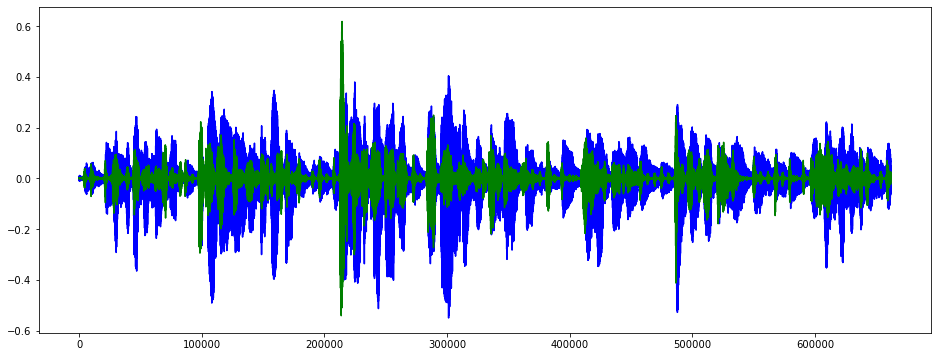

In [47]:
y_harm, y_perc = librosa.effects.hpss(x)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = 'blue');
plt.plot(y_perc, color = 'green');

### - Tempo BPM (Beats per minute)

In [35]:
tempo, _ = librosa.beat.beat_track(y=x, sr = sr)
tempo

117.45383522727273

### - Spectral Centroid
Esso indica dove si trova il centro di massa di un suono ed è calcolato come la media pesata delle frequenze presenti nel suono.

In [49]:
# calcolo spectral centroid
spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]

print('Centroids:', spectral_centroids, '\n')

Centroids: [2237.81781509 2067.50698483 2122.04524217 ... 1189.83374428 1211.37334677
 1471.54237832] 



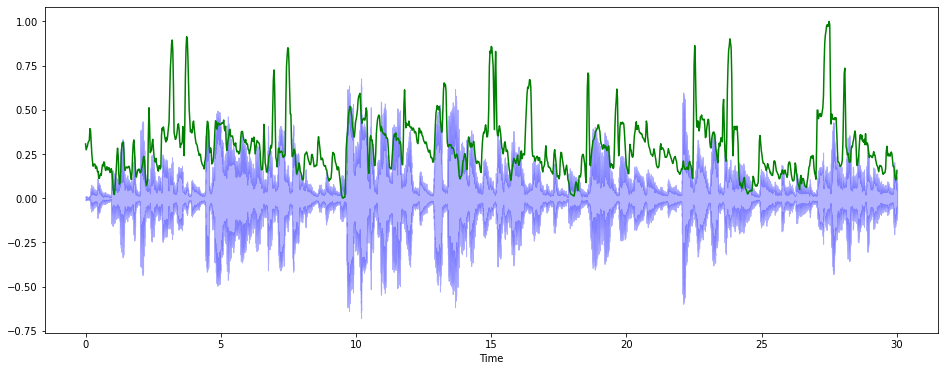

In [50]:
# Time variable per la visualizzazione
frames = range(len(spectral_centroids))

# conversione frames in tempo
t = librosa.frames_to_time(frames)

# funzione che normalizza i dati del suono
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

#Plotting the Spectral Centroid along the waveform

plt.figure(figsize = (16, 6))
librosa.display.waveshow(x, sr=sr, alpha=0.3, color = 'blue');
plt.plot(t, normalize(spectral_centroids), color='green');

### - Spectral Rolloff

E' una misura della forma del segnale. Essa rappresenta la frequenza sotto la quale una percentuale dell'energia dello spettro giace, solitamente l'85%.

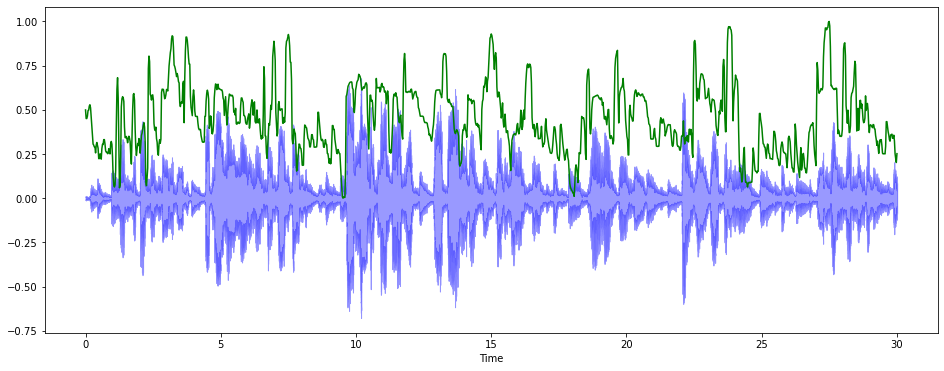

In [51]:
# vettore spectral rolloff
spectral_rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr)[0]

# plot
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y=x, sr=sr, alpha=0.4, color = 'blue');
plt.plot(t, normalize(spectral_rolloff), color='green');

### - Mel-Frequency Cepstral Coefficients

I Mel frequency cepstral coefficients (MFCCs) di un segnale sono un piccolo insieme di features che descrivono la forma complessiva dello spettro. Essi modellano le caratteristiche della voce umana.

mfccs shape: (20, 1293)


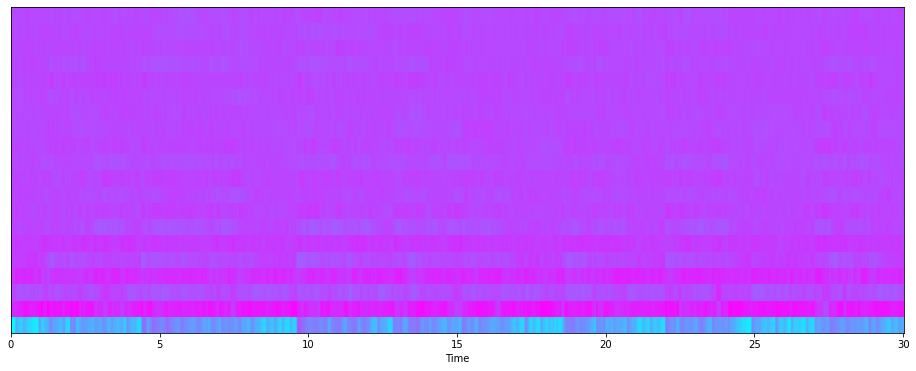

In [53]:
mfccs = librosa.feature.mfcc(y=x, sr=sr)
print('mfccs shape:', mfccs.shape)

#Visualizzazione MFCCs:
plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

Facciamo scaling dei dati per migliorare la visualizzazione

Mean: 8.8508056e-10 

Var: 1.0000001


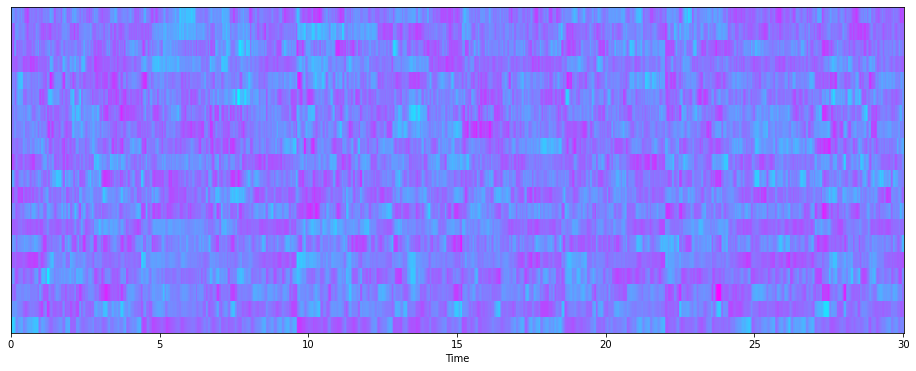

In [54]:
#Feature Scaling
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean(), '\n')
print('Var:', mfccs.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

### - Chroma Frequencies


I chroma features sono una rappresentazione utilizzata per audio musicali in cui l'intero spettro è proiettato in 12 insiemi che rappresentano i 12 diversi semitoni di un'ottava musicale.

Chromogram shape: (12, 133)


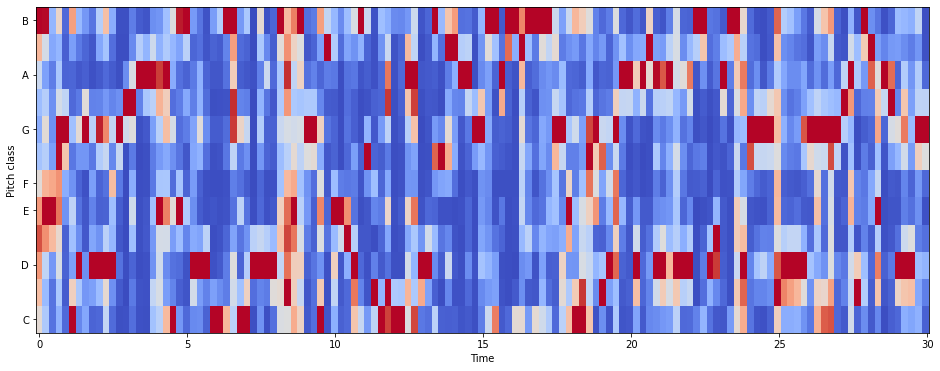

In [60]:
# Aumenta o diminuisci l'hop_length per cambiare la granulosità dei dati
hop_length = 5000

# Chromogram
chromagram = librosa.feature.chroma_stft(y=x, sr=sr, hop_length=hop_length)
print('Chromogram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm');

#### Procediamo ora a definire una funzione in grado di estrapolare dal file audio le features che abbiamo introdotto.



In [61]:
def get_feature(audio_file,genre):
    
    #creating dictionary for the features
    features_dict={}
    
    #audio_title
    
    features_dict['title']=[str(audio_file)]
    
    #loading the audio file
    x, sr = librosa.load(audio_file)
    
    #getting the zero crossing rate mean and var
    zero_crossing=librosa.zero_crossings(x,pad=False)
    features_dict['zero_crossings_rate_mean'] = [np.mean(zero_crossing)]
    features_dict['zero_crossings_rate_var'] = [np.var(zero_crossing)]
    
    #getting the tempo
    tempo, _ = librosa.beat.beat_track(y=x, sr = sr)
    features_dict['tempo']=[tempo]
    
    #getting the spectral_centroids mean and var
    spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]
    features_dict['spectral_centroids_mean'] = [np.mean(spectral_centroids)]
    features_dict['spectral_centroids_var'] = [np.var(spectral_centroids)]
    
    #getting the rms mean and var
    rms=librosa.feature.rms(y=x)
    features_dict['rms_mean']=[np.mean(rms)]
    features_dict['rms_var']=[np.var(rms)]
    
    #getting the chromagram mean and var
    chromagram = librosa.feature.chroma_stft(y=x, sr=sr)
        
    m=[]
    v=[]

    for i in range(chromagram.shape[0]):

        m.append(np.mean(chromagram[i]))
        v.append(np.var(chromagram[i]))

    features_dict['chromagram_mean']=[np.mean(m)]
    features_dict['chromagram_var']=[np.mean(v)]
    
    # getting the mfccs
    
    mfccs = librosa.feature.mfcc(y=x, sr=sr)    
    
    for i in range(mfccs.shape[0]):
        
        features_dict['mfccs_mean_'+str(i)]=[np.mean(mfccs[i])]
        features_dict['mfccs_var_'+str(i)]=[np.var(mfccs[i])]
        
    #getting the spectral rolloff mean and var
    
    spectral_rolloff=librosa.feature.spectral_rolloff(y=x+0.01, sr=sr)[0]
    features_dict['spectral_rolloff_mean'] = [np.mean(spectral_rolloff)]
    features_dict['spectral_rolloff_var'] = [np.var(spectral_rolloff)]
    
    #getting harmony and perceptrual mean and var
    harm, perc = librosa.effects.hpss(x)
    
    features_dict['harm_mean']=[np.mean(harm)]
    features_dict['harm_var']=[np.var(harm)]
    features_dict['perc_mean']=[np.mean(perc)]
    features_dict['per_var']=[np.var(perc)]
    
    #getting spectral bandwidth mean and var
    
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=x,sr=sr)
    features_dict['spectral_band_width_mean']=[np.mean(spectral_bandwidth)]
    features_dict['spectral_band_width_var']=[np.var(spectral_bandwidth)]
    
    #label
    
    features_dict['label'] = [genre]
    
    return pd.DataFrame.from_dict(features_dict,orient='columns')

Nel nostro dataset sono presenti 100 brani musicali di 30 secondi per ciascun genere, per un totale di 1000 campioni. Per poter riconoscere un genere musicale ci sono sufficienti 3-5 secondi di audio.
Procediamo dunque a splittare ciascun file audio in 10 pezzi da 3 secondi in maniera tale da aumentare il numero di dati a disposizione.

In [ ]:
i = 0
for g in genres:
    j=0
    print(f"{g}")
    for filename in os.listdir(os.path.join(r'C:\Users\paolo\OneDrive\Desktop\genr\genres',f"{g}")):
    song  =  os.path.join(r'C:\Users\paolo\OneDrive\Desktop\genr\genres/{}'.format(g),f'{filename}')
    j = j+1
    for w in range(0,10):
        i = i+1
        t1 = 3*(w)*1000
        t2 = 3*(w+1)*1000
        newAudio = AudioSegment.from_wav(song)
        new = newAudio[t1:t2]
        new.export(f'/ML_prog/audio_3_sec/{g}/{g+str(j)+str(w)}.wav', format="wav")

In [ ]:
# creazione dataframe con le features dei file audio

list_dfs=[]

for g in genres:
    
    #print(g)
            
    for filename in os.listdir(os.path.join(r'C:\ML_prog\audio_3_sec',f"{g}")):

        audio_file=os.path.join(r'C:\ML_prog\audio_3_sec/{}'.format(g),f'{filename}')  
        df=get_feature(audio_file,g)
        list_dfs.append(df)

audio_data = pd.concat(list_dfs)

# 2. Preprocessing

In [24]:
# caricamento dataset delle features dei file audio

audio_data = pd.read_csv(r'C:\Users\paolo\OneDrive\Desktop\feature_1000.csv')
audio_data.drop(columns={'Unnamed: 0','title'}, inplace=True)
audio_data.head()

,zero_crossings_rate_mean,zero_crossings_rate_var,tempo,spectral_centroids_mean,spectral_centroids_var,rms_mean,rms_var,chromagram_mean,chromagram_var,mfccs_mean_0,...,mfccs_var_19,spectral_rolloff_mean,spectral_rolloff_var,harm_mean,harm_var,perc_mean,per_var,spectral_band_width_mean,spectral_band_width_var,label
0,0.083220,0.076294,129.199219,1773.358004,169450.829520,0.130189,0.003559,0.335555,0.086077,-119.018044,...,43.818882,3689.548715,1.087928e+06,-0.000047,0.008388,-0.000060,0.005511,1972.334258,117272.640189,blues
1,0.090567,0.082365,107.666016,1998.758310,381713.151506,0.100493,0.003340,0.265217,0.078723,-191.297531,...,144.411591,4182.907527,1.476072e+06,0.000044,0.009748,-0.000034,0.001631,2000.772635,142774.762347,blues
2,0.039864,0.038275,92.285156,1193.435936,41366.235679,0.056540,0.000291,0.430437,0.056609,-253.811722,...,46.520298,2689.248610,3.777204e+05,0.000164,0.002054,0.000599,0.000599,1728.975448,39881.272305,blues
3,0.068193,0.063543,92.285156,1552.012695,287336.910940,0.120740,0.005773,0.401023,0.075884,-169.650101,...,120.789474,3275.862755,1.309533e+06,0.000071,0.011782,0.000705,0.003541,1789.033520,111699.295295,blues
4,0.090733,0.082501,151.999081,1515.561237,100001.383689,0.132596,0.003614,0.348045,0.078494,-139.112396,...,93.030144,2725.689416,5.922495e+05,0.000164,0.013297,0.000545,0.002850,1448.285471,54128.936422,blues


In [25]:
audio_data.shape

(10000, 58)

Effettuiamo uno scaling dei dati per portarli tutti sullo stesso ordine di grandezza.

In [26]:
#vettore labels
y=audio_data['label']

#elimino colonna delle labels
X=audio_data.loc[:, audio_data.columns!='label']

cols=X.columns
min_max_scaler=preprocessing.MinMaxScaler()
data_scaled=min_max_scaler.fit_transform(X)
X=pd.DataFrame(data_scaled,columns=cols)

X.head()

,zero_crossings_rate_mean,zero_crossings_rate_var,tempo,spectral_centroids_mean,spectral_centroids_var,rms_mean,rms_var,chromagram_mean,chromagram_var,mfccs_mean_0,...,mfccs_mean_19,mfccs_var_19,spectral_rolloff_mean,spectral_rolloff_var,harm_mean,harm_var,perc_mean,per_var,spectral_band_width_mean,spectral_band_width_var
0,0.205797,0.292831,0.398969,0.261178,0.034854,0.294058,0.109907,0.353726,0.747454,0.705590,...,0.507204,0.047635,0.379505,0.090535,0.628740,0.066028,0.559304,0.092616,0.458988,0.093845
1,0.227535,0.321129,0.317010,0.306692,0.079078,0.226491,0.103137,0.244353,0.683110,0.611653,...,0.333251,0.157625,0.432293,0.122867,0.630891,0.076730,0.560957,0.027409,0.467851,0.114481
2,0.077515,0.115592,0.258468,0.144078,0.008168,0.126487,0.008973,0.501264,0.489627,0.530408,...,0.312266,0.050589,0.272475,0.031376,0.633703,0.016172,0.601367,0.010058,0.383145,0.031223
3,0.161336,0.233387,0.258468,0.216483,0.059415,0.272559,0.178287,0.455526,0.658273,0.639787,...,0.438712,0.131796,0.335242,0.108995,0.631524,0.092743,0.608134,0.059511,0.401862,0.089335
4,0.228027,0.321763,0.485749,0.209123,0.020385,0.299535,0.111602,0.373147,0.681106,0.679475,...,0.586205,0.101444,0.276374,0.049246,0.633704,0.104671,0.597902,0.047902,0.295667,0.042751


Effettuo lo splitting in train e test.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Confronto modelli di classificazione

In [31]:
def model_evaluation(model, title):
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print('Accuracy', title, ':', round(accuracy_score(y_test, pred), 5), '\n')
    

In [32]:
# Perceptron
perceptron = Perceptron()
model_evaluation(perceptron, "Perceptron")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_evaluation(lg, "Logistic Regression")

# Support vector machine
svm = SVC(decision_function_shape="ovo")
model_evaluation(svm, "SVM")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_evaluation(knn, "KNN")

# Random forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_evaluation(rforest,"Random forest")

# Decision tree
tree = DecisionTreeClassifier()
model_evaluation(tree,"Decision Tree")


Accuracy Perceptron : 0.5965 

Accuracy Logistic Regression : 0.704 

Accuracy SVM : 0.773 

Accuracy KNN : 0.8365 

Accuracy Random forest : 0.8205 

Accuracy Decision Tree : 0.65 



Il modello più accurato è KNN. Visualizziamo la sua confusion matrix per avere un'idea visiva delle sue performance.

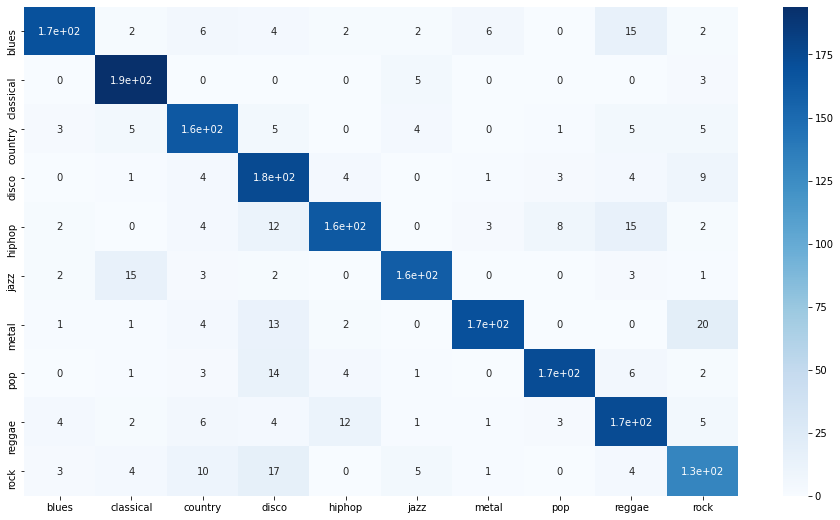

In [33]:
# Confusion Matrix

knn.fit(X_train, y_train)
pred = knn.predict(X_test)


confusion_matr = confusion_matrix(y_test, pred)
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);

# Convolutional neural network

Una maniera alternativa per poter classificare i file audio musicali in base al loro genere è quella di utilizzare il loro MEL spectogram.

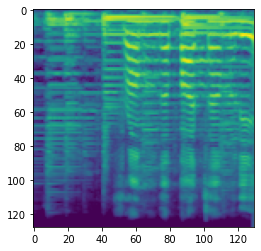

In [43]:
x, sr = librosa.load(r'C:\Users\paolo\OneDrive\Desktop\genr\genres\reggae\reggae.00010.wav',duration=3)
mels = librosa.feature.melspectrogram(y=x,sr=sr)
fig = plt.Figure()
canvas = FigureCanvas(fig)
p = plt.imshow(librosa.power_to_db(mels,ref=np.max))

Procederemo ad addestrare un modello di CNN a distinguere i MEL spectogram che caratterizzano ciascun genere musicale. Anche in questo caso utilizzeremo i file audio della durata di 3 secondi per poter avere un numero maggiore di dati su cui allenare il modello.

In [ ]:
#creazione directories

os.makedirs('/ML_prog/sptg_3_sec')
os.makedirs('/ML_prog/sptg_3_sec/train')
os.makedirs('/ML_prog/sptg_3_sec/test')

for g in genres:
    os.makedirs(f'/ML_prog/sptg_3_sec/test/{g}')
    os.makedirs(f'/ML_prog/sptg_3_sec/train/{g}')

Procedo alla generazione dei MEL Spectogram.
Warning : Richiede molto tempo di computazione, vengono generate 10000 immagini.

In [ ]:
for g in genres:
    
    j = 0
    print(g)
    
    for filename in os.listdir(os.path.join('/ML_prog/audio_3_sec',f"{g}")):
        song  =  os.path.join(f'/ML_prog/audio_3_sec/{g}',f'{filename}')
        j = j+1
        y,sr = librosa.load(song,duration=3)
        mels = librosa.feature.melspectrogram(y=y,sr=sr)
        fig = plt.Figure()
        canvas = FigureCanvas(fig)
        p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
        plt.savefig(f'/ML_prog/sptg_3_sec/train/{g}/{g+str(j)}.png')

In [151]:
#effettuo suddivisione in train-test

directory = '/ML_prog/sptg_3_sec/train'

for g in genres:
    
    filenames = os.listdir(os.path.join(directory, f'{g}'))
    
    random.shuffle(filenames)
    
    test_files = filenames[0:200]
    
    for f in test_files:
        
        shutil.move(directory +'/'+ f'{g}' +'/'+ f, '/ML_prog/sptg_3_sec/test/' + f'{g}' )

In [3]:
train_dir = '/ML_prog/sptg_3_sec/train'
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=128)

validation_dir='/ML_prog/sptg_3_sec/test'
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=128)


Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [13]:
model = keras.models.Sequential([
    
    keras.layers.Input((288,432,4)),
    
    keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(1,1)),
    keras.layers.BatchNormalization(axis=3),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=2,strides=2),
    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=(1,1)),
    keras.layers.BatchNormalization(axis=3),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=2,strides=2),
    
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1)),
    keras.layers.BatchNormalization(axis=3),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=2,strides=2),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1)),
    keras.layers.BatchNormalization(axis=3),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=2,strides=2),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1)),
    keras.layers.BatchNormalization(axis=3),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=2,strides=2),
    
    keras.layers.Flatten(),
    keras.layers.Dropout(rate=0.3),
    
    keras.layers.Dense(units=10, activation='softmax')

])

In [14]:
opt=keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer = opt ,loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
history = model.fit(train_generator,epochs=70,validation_data=valid_generator)

Epoch 1/70
63/63 [==============================] - 753s 12s/step - loss: 2.5156 - accuracy: 0.2576 - val_loss: 2.7425 - val_accuracy: 0.1000
Epoch 2/70
63/63 [==============================] - 734s 12s/step - loss: 1.5425 - accuracy: 0.4535 - val_loss: 5.5884 - val_accuracy: 0.1000
Epoch 3/70
63/63 [==============================] - 737s 12s/step - loss: 1.2629 - accuracy: 0.5611 - val_loss: 8.4590 - val_accuracy: 0.1000
Epoch 4/70
63/63 [==============================] - 726s 12s/step - loss: 1.0756 - accuracy: 0.6313 - val_loss: 9.5009 - val_accuracy: 0.1000
Epoch 5/70
63/63 [==============================] - 749s 12s/step - loss: 1.0058 - accuracy: 0.6510 - val_loss: 6.4789 - val_accuracy: 0.1465
Epoch 6/70
63/63 [==============================] - 744s 12s/step - loss: 0.8478 - accuracy: 0.7079 - val_loss: 3.0911 - val_accuracy: 0.3405
Epoch 7/70
63/63 [==============================] - 715s 11s/step - loss: 0.7898 - accuracy: 0.7260 - val_loss: 1.7662 - val_accuracy: 0.5035
Epoch 

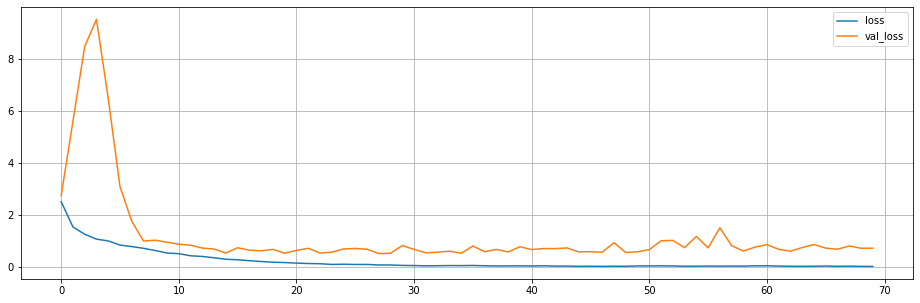

In [21]:
plot_dict_loss={'loss' : history.history['loss'], 'val_loss' : history.history['val_loss']}
pd.DataFrame.from_dict(plot_dict_loss).plot(grid=True,figsize=(16,5));

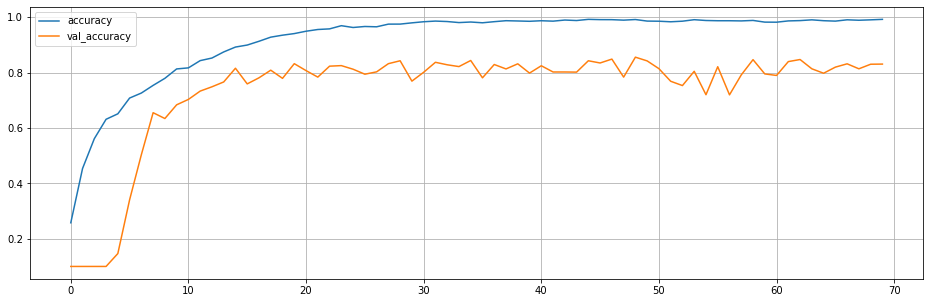

In [22]:
plot_dict_accuracy={'accuracy' : history.history['accuracy'], 'val_accuracy' : history.history['val_accuracy']}
pd.DataFrame.from_dict(plot_dict_accuracy).plot(grid=True,figsize=(16,5));